# Ensure correct WP3 environment

In [1]:
import os
import time
import argparse
import pandas as pd
import numpy as np
import torch
import sklearn.metrics
import json
import scipy.sparse as sparse
from scipy.stats import spearmanr
from  pathlib import Path
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import ptitprince as pt

%matplotlib
%pylab inline
import matplotlib.ticker as ticker

#cut function
def cut(x, bins, lower_infinite=True, upper_infinite=True, **kwargs):        
    num_labels      = len(bins) - 1
    include_lowest  = kwargs.get("include_lowest", False)
    right           = kwargs.get("right", True)
    bins_final = bins.copy()
    if upper_infinite:
        bins_final.insert(len(bins),float("inf"))
        num_labels += 1
    if lower_infinite:
        bins_final.insert(0,float("-inf"))
        num_labels += 1
    symbol_lower  = "<=" if include_lowest and right else "<"
    left_bracket  = "(" if right else "["
    right_bracket = "]" if right else ")"
    symbol_upper  = ">" if right else ">="
    labels=[]
    
    def make_label(i, lb=left_bracket, rb=right_bracket):
        return "{0}{1}-{2}{3}".format(lb, bins_final[i], bins_final[i+1], rb)
        
    for i in range(0,num_labels):
        new_label = None
        if i == 0:
            if lower_infinite:
                new_label = "{0} {1}".format(symbol_lower, bins_final[i+1])
            elif include_lowest:
                new_label = make_label(i, lb="[")
            else:
                new_label = make_label(i)
        elif upper_infinite and i == (num_labels - 1):
            new_label = "{0} {1}".format(symbol_upper, bins_final[i])
        else:
            new_label = make_label(i)
        labels.append(new_label)
    return pd.cut(x, bins_final, labels=labels, **kwargs)

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
print(f"pd:{pd.__version__}")
print(f"np:{np.__version__}")
print(f"sns:{sns.__version__}")

pd:1.1.3
np:1.16.5
sns:0.10.0


# set the files

In [3]:
y_true_all= ''              #help="Activity file (npy) (i.e. from files_4_ml/)", type=str, required=True)
task_map = ''               #help="Taskmap from MELLODDY_tuner output of single run (i.e. from results/weight_table_T3_mapped.csv)", required=True)
folding = ''                #help="LSH Folding file (npy) (i.e. from files_4_ml/)", type=str, required=True)
validation_fold = 0        #help="Validation fold to used to calculate performance", type=int, default=0, choices=[0, 1, 2, 3, 4])
min_size = 5               #help="Minimum size of the task (NB: defaults to 25)", type=int, default=25, required=False)
f1  = ''                    #help="Output 1 (i.e. from the SP run) to compare (pred or .npy)", type=str, required=True)
f2 = ''                     #help="Output 2 (i.e. from the MP run) run to compare (pred or .npy)", type=str, required=True)

# load the yhats + calc performance

In [5]:
#find f1 
def find_max_f1(precision, recall):
    F1	= np.zeros(len(precision))
    mask = precision > 0
    F1[mask] = 2 * (precision[mask] * recall[mask]) / (precision[mask] + recall[mask])
    return F1.max()

#load either pred or npy yhats and mask if needed, for an input filename
def load_yhats(input_f, folding, fold_va, y_true):
    # load the data
    if input_f.suffix == '.npy':
        yhats = np.load(input_f, allow_pickle=True).item().tocsr().astype('float32')
        ftype = 'npy'
    else:
        yhats = torch.load(input_f).astype('float32')
        ftype = 'pred'
    # mask validation fold if possible
    try: yhats = yhats[folding == fold_va]
    except IndexError: pass
    return yhats, ftype

#perform masking, report any error in shapes, and return data for f1 and f2
def mask_y_hat(f1_path, f2_path, folding, fold_va, y_true):
    true_data = y_true.astype(np.uint8).todense()
    f1_yhat, f1_ftype = load_yhats(f1_path, folding, fold_va, y_true)
    assert true_data.shape == f1_yhat.shape, f"True shape {true_data.shape} and {f1} shape {f1_yhat.shape} need to be identical"
    f2_yhat, f2_ftype = load_yhats(f2_path, folding, fold_va, y_true)
    assert true_data.shape == f2_yhat.shape, f"True shape {true_data.shape} and {f2} shape {f2_yhat.shape} need to be identical"
    return [f1_yhat, f2_yhat, f1_ftype, f2_ftype]

## check the pre_calculated_performance with the reported performance json
def per_run_performance(y_pred, pred_or_npy, tasks_table, y_true, tw_df, task_map):
    if pred_or_npy == 'npy': y_pred = sparse.csc_matrix(y_pred)
    assert y_true.shape == y_pred.shape, f"y_true shape do not match {pred_or_npy} y_pred ({y_true.shape} & {y_pred.shape})"
    assert y_true.nnz == y_pred.nnz, f"y_true number of nonzero values do not match {pred_or_npy} y_pred"
    assert (y_true.indptr == y_pred.indptr).all(), f"y_true indptr do not match {pred_or_npy} y_pred"
    assert (y_true.indices == y_pred.indices).all(), f"y_true indices do not match {pred_or_npy} y_pred"

    yhats,ytrue,ysizes=[],[],[]
    task_id = np.full(y_true.shape[1], "", dtype=np.dtype('U30'))
    assay_type = np.full(y_true.shape[1], "", dtype=np.dtype('U30'))
    task_size	= np.full(y_true.shape[1], np.nan)
    aucpr	= np.full(y_true.shape[1], np.nan)
    logloss = np.full(y_true.shape[1], np.nan)
    aucroc  = np.full(y_true.shape[1], np.nan)
    maxf1	= np.full(y_true.shape[1], np.nan)
    kappa	= np.full(y_true.shape[1], np.nan)
    brier	= np.full(y_true.shape[1], np.nan)
    tn	 = np.full(y_true.shape[1], np.nan)
    fp	 = np.full(y_true.shape[1], np.nan)
    fn	 = np.full(y_true.shape[1], np.nan)
    tp	 = np.full(y_true.shape[1], np.nan)

    num_pos = (y_true == +1).sum(0)
    num_neg = (y_true == -1).sum(0)
    cols55  = np.array((num_pos >= min_size) & (num_neg >= min_size)).flatten()
    for col in range(y_true.shape[1]):
        y_true_col = y_true.data[y_true.indptr[col] : y_true.indptr[col+1]] == 1
        y_pred_col = y_pred.data[y_pred.indptr[col] : y_pred.indptr[col+1]]
        y_true_col, y_pred_col = y_true_col.astype(np.uint8), y_pred_col.astype('float32')
        #check y_true_col
        if y_true_col.shape[0] <= 1: continue
        if (y_true_col[0] == y_true_col).all(): continue
        task_id[col] = tasks_table["classification_task_id"][tasks_table["cont_classification_task_id"]==col].iloc[0]
        assay_type[col] = tasks_table["assay_type"][tasks_table["cont_classification_task_id"]==col].iloc[0]
        task_size[col] = len(y_true_col)
        y_classes = np.where(y_pred_col > 0.5, 1, 0).astype(np.uint8)
        yhats+=list(y_pred_col)
        ytrue+=list(y_true_col)
        ysizes+=[len(y_true_col)] * len(y_true_col)
        precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true = y_true_col, probas_pred = y_pred_col)
        aucpr[col]  = sklearn.metrics.auc(x = recall, y = precision)
        #logloss must be float64 to avoid issues with nans in output (e.g. https://stackoverflow.com/questions/50157689/)
        logloss[col]  = sklearn.metrics.log_loss(y_true=y_true_col.astype("float64"), y_pred=y_pred_col.astype("float64"))
        aucroc[col] = sklearn.metrics.roc_auc_score(y_true=y_true_col, y_score=y_pred_col)
        maxf1[col]  = find_max_f1(precision, recall)
        kappa[col]  = sklearn.metrics.cohen_kappa_score(y_true_col, y_classes)
        brier[col] = sklearn.metrics.brier_score_loss(y_true=y_true_col, y_prob=y_pred_col)
        tn[col], fp[col], fn[col], tp[col] = sklearn.metrics.confusion_matrix(y_true = y_true_col, y_pred = y_classes).ravel()
        ##per-task performance:
        cols = ['classification_task_id', 'assay_type', 'task_size', 'aucpr','aucroc','logloss','maxf1','kappa','brier','tn','fp','fn','tp']
        local_performance=pd.DataFrame(np.array([task_id[cols55],assay_type[cols55],task_size[cols55],aucpr[cols55],aucroc[cols55],logloss[cols55],maxf1[cols55],\
            kappa[cols55],brier[cols55],tn[cols55],fp[cols55],fn[cols55],tp[cols55]]).T, columns=cols)
    ##correct the datatypes for numeric columns
    for c in local_performance.iloc[:,2:].columns:
        local_performance.loc[:,c] = local_performance.loc[:,c].astype('float32')
    df = local_performance[:]
    df['classification_task_id'] = df['classification_task_id'].astype('int32')
    df = df.merge(task_map, right_on=["classification_task_id","assay_type"], left_on=["classification_task_id","assay_type"], how="left")
    return [df,yhats,ytrue,ysizes]


In [6]:
y_pred_f1_path = Path(f1)
y_pred_f2_path = Path(f2)
task_map = pd.read_csv(task_map)
folding = np.load(folding)
try: y_true_all = np.load(y_true_all, allow_pickle=True).item()
except AttributeError: 
    from scipy.io import mmread 
    y_true_all = mmread(y_true_all)
y_true_all = y_true_all.tocsc()
fold_va = validation_fold
y_true = y_true_all[folding == fold_va]
y_true_all = None
tw_df = np.ones(y_true.shape[1], dtype=np.uint8)

In [7]:
f1_yhat, f2_yhat, f1_ftype, f2_ftype = mask_y_hat(y_pred_f1_path,y_pred_f2_path, folding, fold_va, y_true)
folding, fold_va = None, None

In [8]:
f1_report,f1yhat,f1truelabel,f1sizes = per_run_performance(f1_yhat, f1_ftype, task_map, y_true, tw_df, task_map)
f1_yhat = None #clear yhat from memory - no longer needed

f2_report,f2yhat,f2truelabel,f2sizes = per_run_performance(f2_yhat, f2_ftype, task_map, y_true, tw_df, task_map)
f2_yhat=None #clear yhat from memory - no longer needed

y_true, tw_df = None, None #clear ytrue and weights - no longer needed

# Perform calibration evaluation

In [34]:
#set up the SP + MP dataframes
df_f1_calibration=pd.DataFrame([f1yhat,f1truelabel,f1sizes]).T
df_f1_calibration.columns=['yhat','ytrue','tasksize']
df_f1_calibration['taskbin'] = cut(df_f1_calibration['tasksize'].astype('float32'), \
[25,100,1000,10000],include_lowest=True,right=True)

df_f2_calibration=pd.DataFrame([f2yhat,f2truelabel,f2sizes]).T
df_f2_calibration.columns=['yhat','ytrue','tasksize']
df_f2_calibration['taskbin'] = cut(df_f2_calibration['tasksize'].astype('float32'), \
[25,100,1000,10000],include_lowest=True,right=True)

In [35]:
#calculate the SP+MP calibration plots
nbin=50
f1calc = np.array(np.hstack((np.array(([0],[0])),calibration_curve(f1truelabel,f1yhat,n_bins=nbin),np.array(([1],[1])))))
f1cords = np.vstack((['SP']*(nbin+2),['ALL']*(nbin+2),f1calc))
for tbin,tbin_df in df_f1_calibration.groupby('taskbin'):
    f1calc = np.array(np.hstack((np.array(([0],[0])),calibration_curve(tbin_df['ytrue'],tbin_df['yhat'],n_bins=nbin),np.array(([1],[1])))))
    f1cords_temp = np.vstack((['SP']*(nbin+2),[tbin]*(nbin+2),f1calc))
    f1cords = np.hstack((f1cords,f1cords_temp))
    
nbin=50
f2calc = np.array(np.hstack((np.array(([0],[0])),calibration_curve(f2truelabel,f2yhat,n_bins=nbin),np.array(([1],[1])))))
f2cords = np.vstack((['MP']*(nbin+2),['ALL']*(nbin+2),f2calc))
for tbin,tbin_df in df_f2_calibration.groupby('taskbin'):
    f2calc = np.array(np.hstack((np.array(([0],[0])),calibration_curve(tbin_df['ytrue'],tbin_df['yhat'],n_bins=nbin),np.array(([1],[1])))))
    f2cords_temp = np.vstack((['MP']*(nbin+2),[tbin]*(nbin+2),f2calc))
    f2cords = np.hstack((f2cords,f2cords_temp))

In [13]:
#aggregate SP + MP calibration results 
outcords = pd.DataFrame(np.hstack((f1cords,f2cords))).T
outcords.columns=['Run type','binsize','FRACT','PROBA']
outcords['FRACT']=outcords['FRACT'].astype(float)
outcords['PROBA']=outcords['PROBA'].astype(float)

/projects/mai/users/kljk345/.conda/envs/melloddy_combined/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
/projects/mai/users/kljk345/.conda/envs/melloddy_combined/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
/projects/mai/users/kljk345/.conda/envs/melloddy_combined/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
/projects/mai/users/kljk345/.conda/envs/melloddy_combined/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were dep

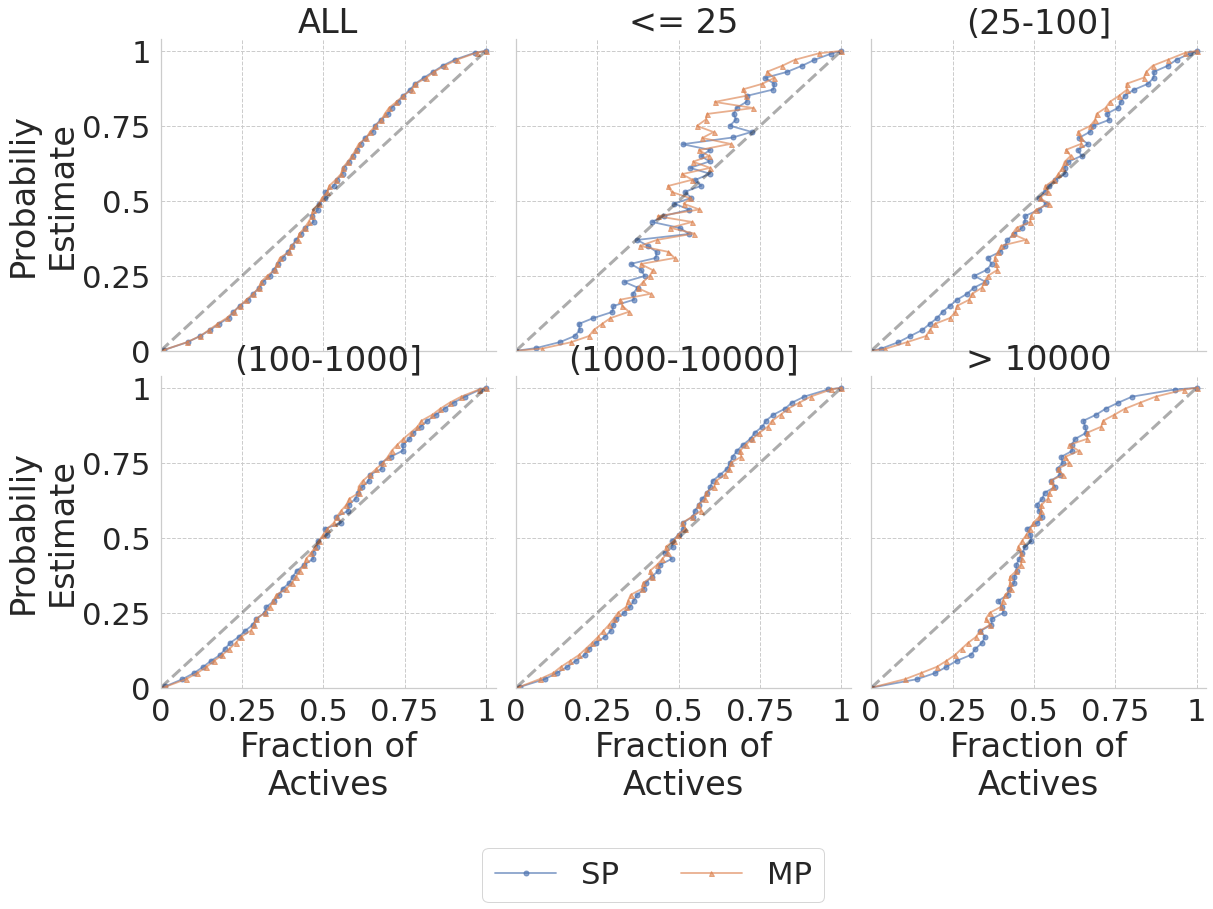

In [14]:
#plot SP + MP calibration results 
sns.set_context("poster")
sns.set(font_scale=2.8)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.FacetGrid(outcords, col='binsize', hue="Run type", height=5.5,col_wrap=3,hue_kws=dict(marker=["o", "^"]),margin_titles=True,sharex=True,sharey=True,palette='deep')
g = g.map(plt.plot, "FRACT", "PROBA")

for axs in g.axes.flat:
    for l in axs.lines:
        plt.setp(l,linewidth=1.8)
        plt.setp(l,markersize=5)
        plt.setp(l,alpha=0.65)

def const_line(*args, **kwargs):
    x = np.arange(0, 1.01, .5)
    y = np.arange(0, 1.01, .5)
    plt.plot(y, x, C='k', linestyle='--', alpha=0.2, linewidth=3)
g.map(const_line)

#g.set_xticklabels(rotation=90)
g.set_titles(row_template = '     {row_name}     ', col_template = '{col_name}')
g.set_xlabels('Fraction of\nActives')
g.set_ylabels('Probabiliy\nEstimate')
g.set(ylim=(0, 1.04))
g.set(xlim=(0, 1.03))

for ax in g.axes.flat:
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.9,box.height])

plt.legend(loc='center',bbox_to_anchor=(-0.65,-0.60),ncol=2)
plt.subplots_adjust(wspace=0.06, hspace=0.08)
ax.xaxis.set_major_locator(ticker.MultipleLocator(.25))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.25))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


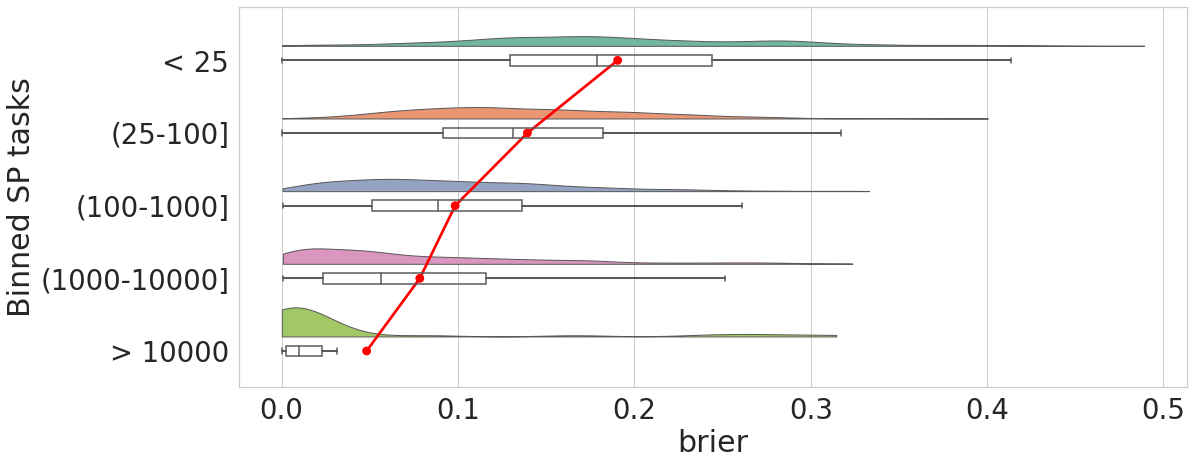

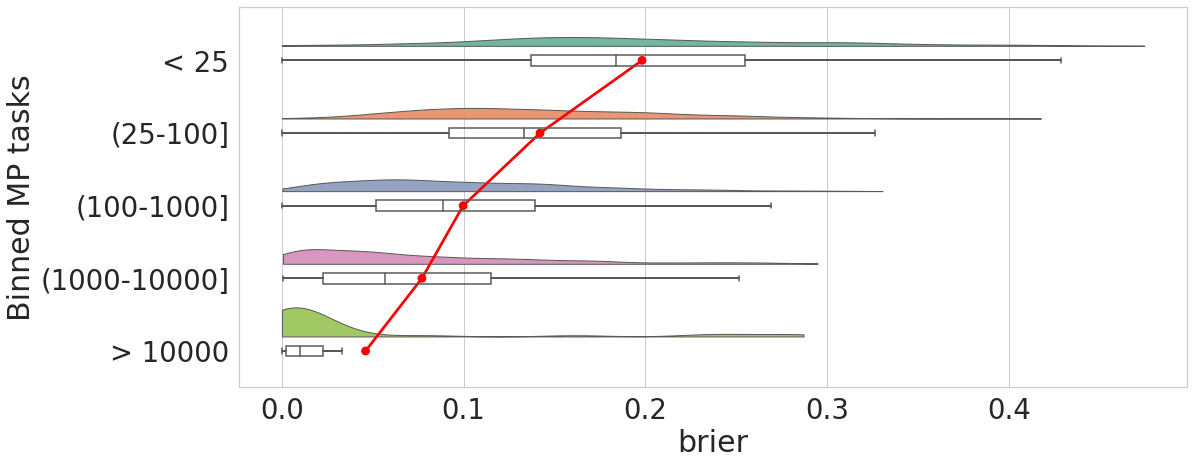

In [36]:
#show calibration / brier performance for SP + MP calibration results 
%matplotlib
%pylab inline
import ptitprince as pt
f1_report['Binned SP tasks']=cut(f1_report['task_size'], [25,100,1000,10000],lower_infinite=True, upper_infinite=True)
plt.figure(figsize=(17,7))
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
ax=pt.RainCloud(x = 'Binned SP tasks', y = 'brier', data = f1_report, palette='Set2',point_size=0, box_showfliers=False,
                 width_viol = .8,orient='h',move = .2,pointplot=True)

f2_report['Binned MP tasks']=cut(f2_report['task_size'], [25,100,1000,10000],lower_infinite=True, upper_infinite=True)
plt.figure(figsize=(17,7))
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
ax=pt.RainCloud(x = 'Binned MP tasks', y = 'brier', data = f2_report, palette='Set2',point_size=0, box_showfliers=False,
                 width_viol = .8,orient='h',move = .2,pointplot=True)

# bland altman / yhat analysis

In [15]:
#set up bland altmans df
df_f1_calibration.columns=[i+'SP' for i in df_f1_calibration.columns]
blandaltman=pd.concat([df_f2_calibration,df_f1_calibration],axis=1)
blandaltman
blandaltman['∆yhat']=blandaltman['yhat']-blandaltman['yhatSP']
blandaltman['mean']=(blandaltman['yhat']+blandaltman['yhatSP'])/2

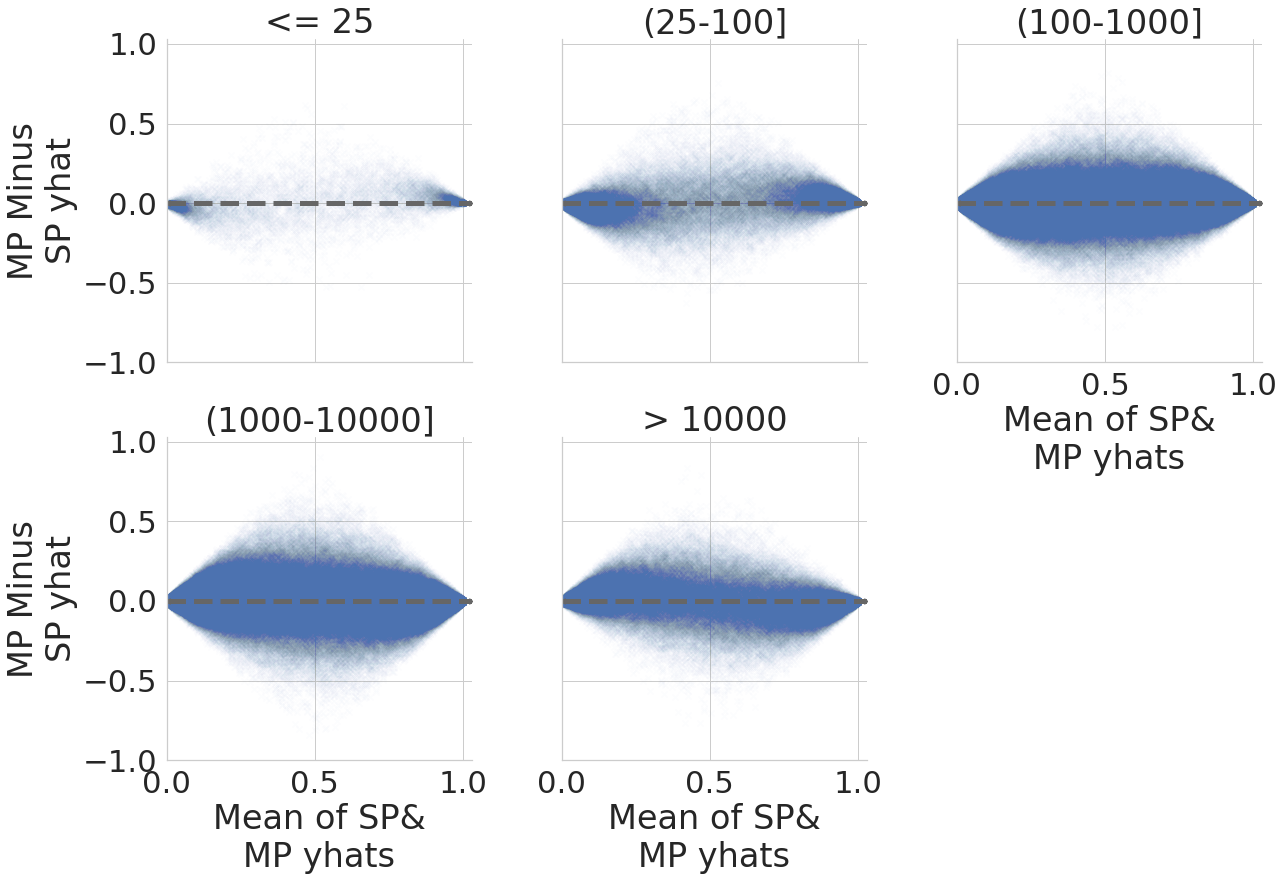

In [16]:
#plot bland altman by size
sns.set_context("poster")
sns.set(font_scale=2.8)
sns.set_style('whitegrid')
g = sns.FacetGrid(blandaltman, col="taskbin", margin_titles=True,col_wrap=3,height=6,hue_kws=dict(marker=["x"]),sharex=True,sharey=True)
g = g.map(plt.scatter, "mean", "∆yhat", edgecolor="w",alpha=.01)
g.map(plt.axhline, y=0, ls="--", c=".4",linewidth=5)
g.set_titles(row_template = '             {row_name}         ', col_template = '{col_name}')
g.set_ylabels('MP Minus\nSP yhat')
g.set_xlabels('Mean of SP&\nMP yhats')
g.set(xlim=(0, 1.03))
g.set(ylim=(-1.0, 1.03))
for ax in g.axes.flat:
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.9,box.height])
ax.xaxis.set_major_locator(ticker.MultipleLocator(.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.5))
plt.show()

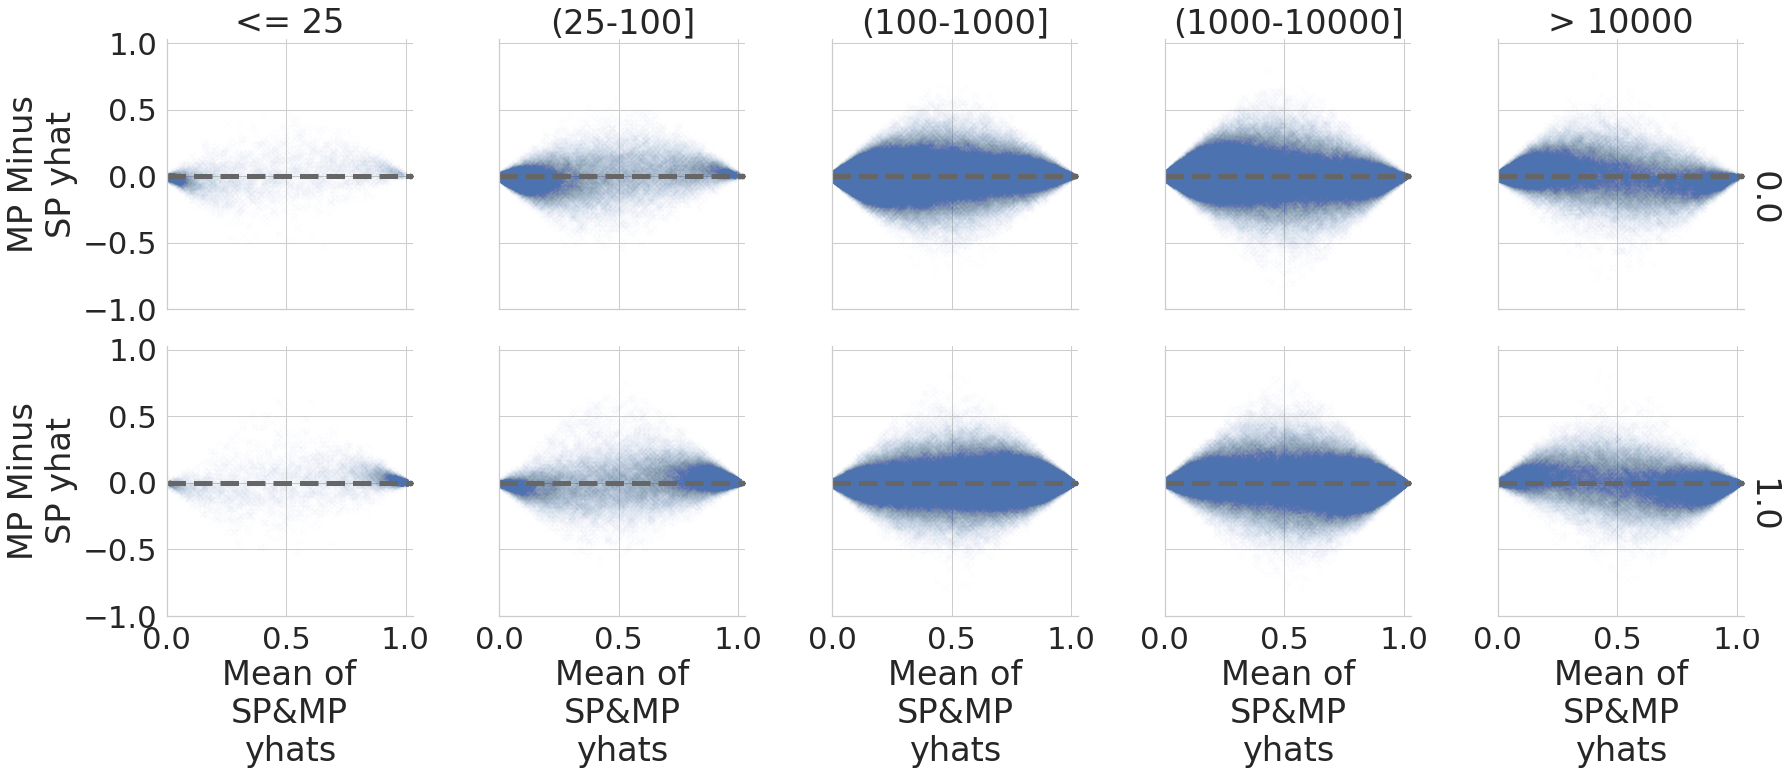

In [17]:
#plot bland altman by size and label
sns.set_context("poster")
sns.set(font_scale=2.8)
sns.set_style('whitegrid')
g = sns.FacetGrid(blandaltman,row='ytrue', col="taskbin", margin_titles=True,height=5,hue_kws=dict(marker=["x"]),sharex=True,sharey=True)
g = g.map(plt.scatter, "mean", "∆yhat", edgecolor="w",alpha=.01)
g.map(plt.axhline, y=0, ls="--", c=".4",linewidth=5)
g.set_titles(row_template = '             {row_name}         ', col_template = '{col_name}')
g.set_ylabels('MP Minus\nSP yhat')
g.set_xlabels('Mean of\nSP&MP\nyhats')
g.set(xlim=(0, 1.03))
g.set(ylim=(-1.0, 1.03))
for ax in g.axes.flat:
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.9,box.height])
ax.xaxis.set_major_locator(ticker.MultipleLocator(.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.5))
plt.show()

# effect of task size on performance

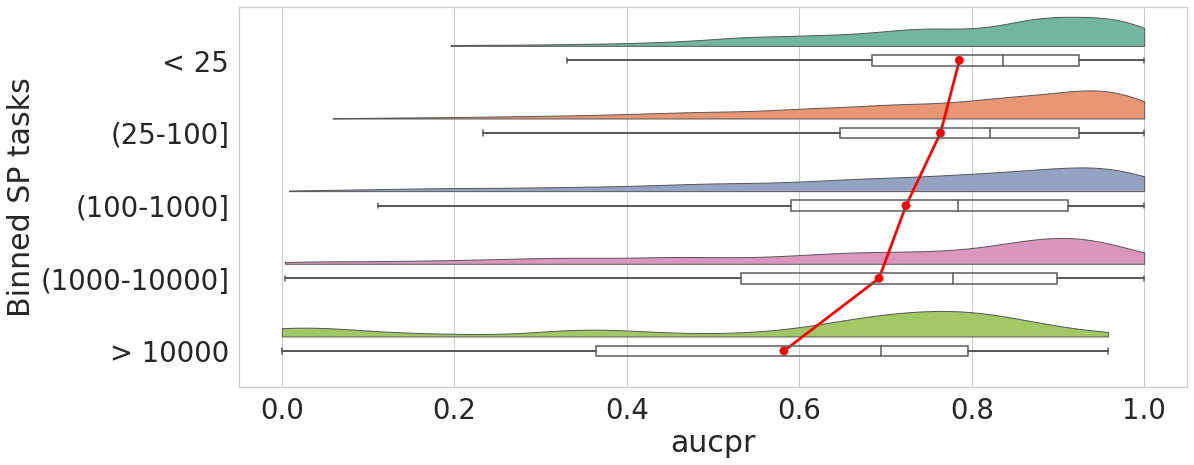

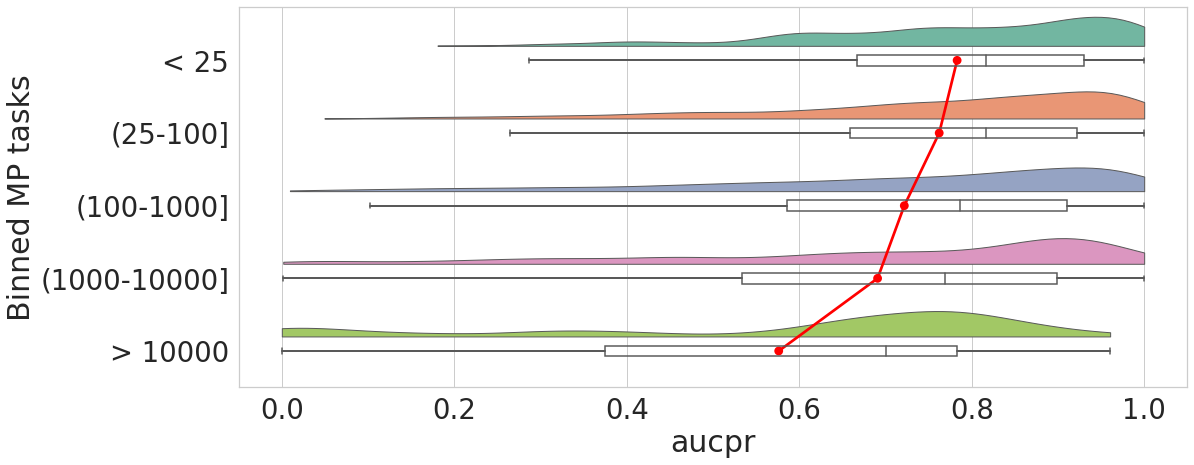

In [37]:
f1_report['Binned SP tasks']=cut(f1_report['task_size'], [25,100,1000,10000],lower_infinite=True, upper_infinite=True)
plt.figure(figsize=(17,7))
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
ax=pt.RainCloud(x = 'Binned SP tasks', y = 'aucpr', data = f1_report, palette='Set2',point_size=0, box_showfliers=False,
                 width_viol = .8,orient='h',move = .2,pointplot=True)

f2_report['Binned MP tasks']=cut(f2_report['task_size'], [25,100,1000,10000],lower_infinite=True, upper_infinite=True)
plt.figure(figsize=(17,7))
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
ax=pt.RainCloud(x = 'Binned MP tasks', y = 'aucpr', data = f2_report, palette='Set2',point_size=0, box_showfliers=False,
                 width_viol = .8,orient='h',move = .2,pointplot=True)

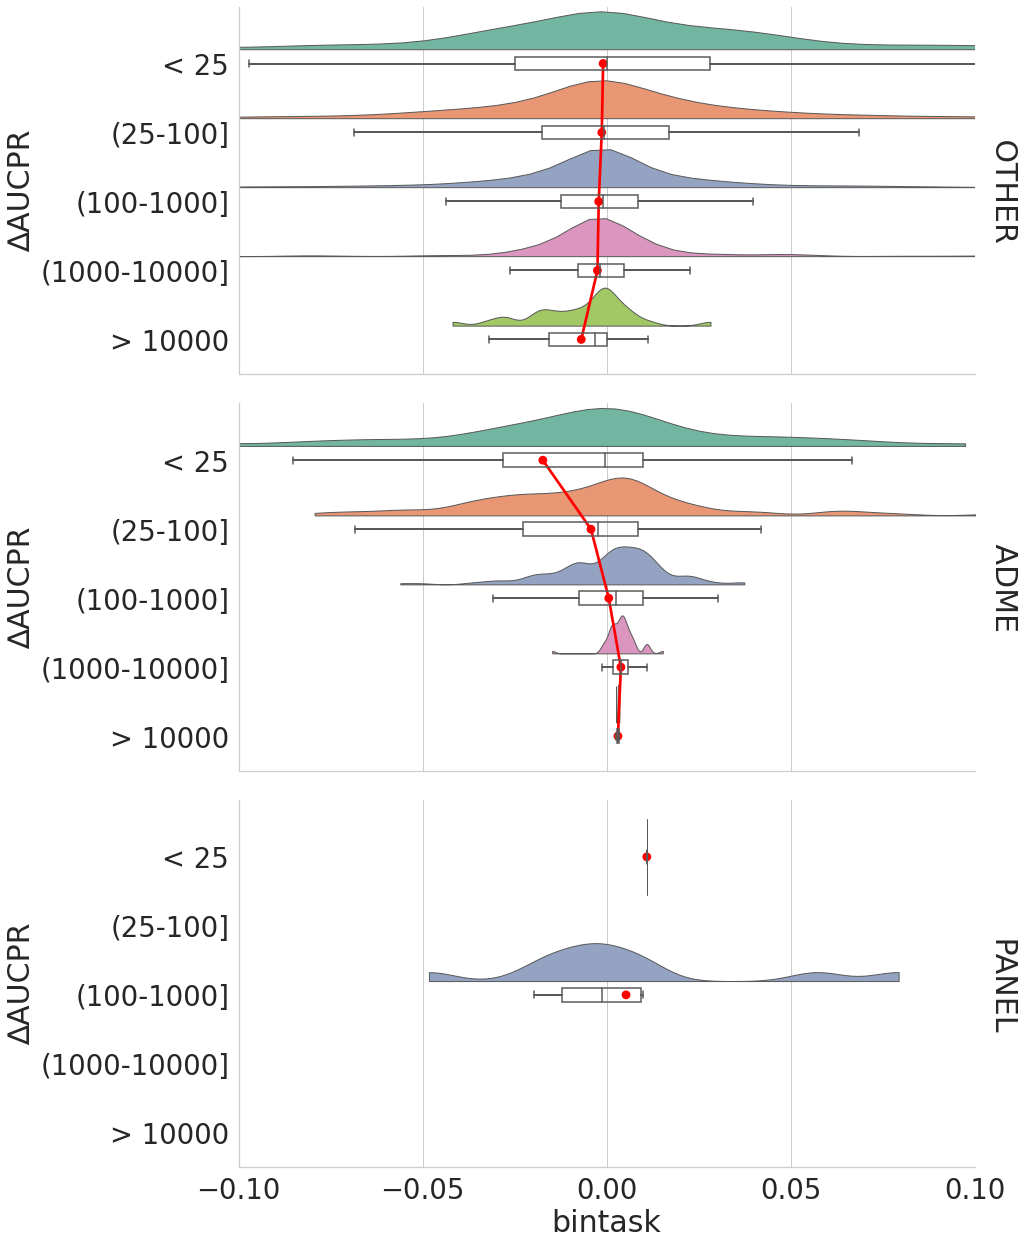

In [109]:
#delta AUCPR by task size and task type
g = sns.FacetGrid(data=deltas,row="assay_type",margin_titles=True,height=6,aspect=2.5)
g = g.map(pt.RainCloud, "bintask","∆AUCPR",orient='h',pointplot = True,\
          scale='width',width_viol = 1.1,move=.9,box_showfliers=False,width_box=.2,point_size=0)
g.set_titles(row_template = '           {row_name}           ')
g.set(xlim=(-.1, .1))
for ax in g.axes.flat:
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.9,box.height])
ax.xaxis.set_major_locator(ticker.MultipleLocator(.05))
plt.subplots_adjust(wspace=0.06, hspace=0.08)


In [103]:
#function to plot metrics by task size and task type
def plotDelta(metric):
    deltas=f2_report[['classification_task_id','assay_type',metric,'bintask']]
    deltas=deltas.merge(f1_report[['classification_task_id',metric]],left_on='classification_task_id',right_on='classification_task_id')
    deltas[f'∆{metric}']=deltas[f'{metric}_x']-deltas[f'{metric}_y']
    deltas[f'∆{metric}']=deltas[f'∆{metric}'].astype(float)

    plt.figure(figsize=(17,7))
    sns.set(font_scale=2.5)
    sns.set_style("whitegrid")
    ax=pt.RainCloud(x = 'bintask', y = f'∆{metric}',hue='assay_type',alpha=.3,\
                    data = deltas, palette='Set2',point_size=0,box_showfliers=False,
                    box_linewidth=2.5, scale='width',
                    width_viol = .8,orient='h',move = .9,pointplot=True, dodge=False,\
                    linecolor='k',width_box = .3, point_scatter_kws={'alpha':0.3})
    ax.set_xlim(-0.1,0.1)
    plt.axvline( x=0, ls="--", c=".6",linewidth=4)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(.02))

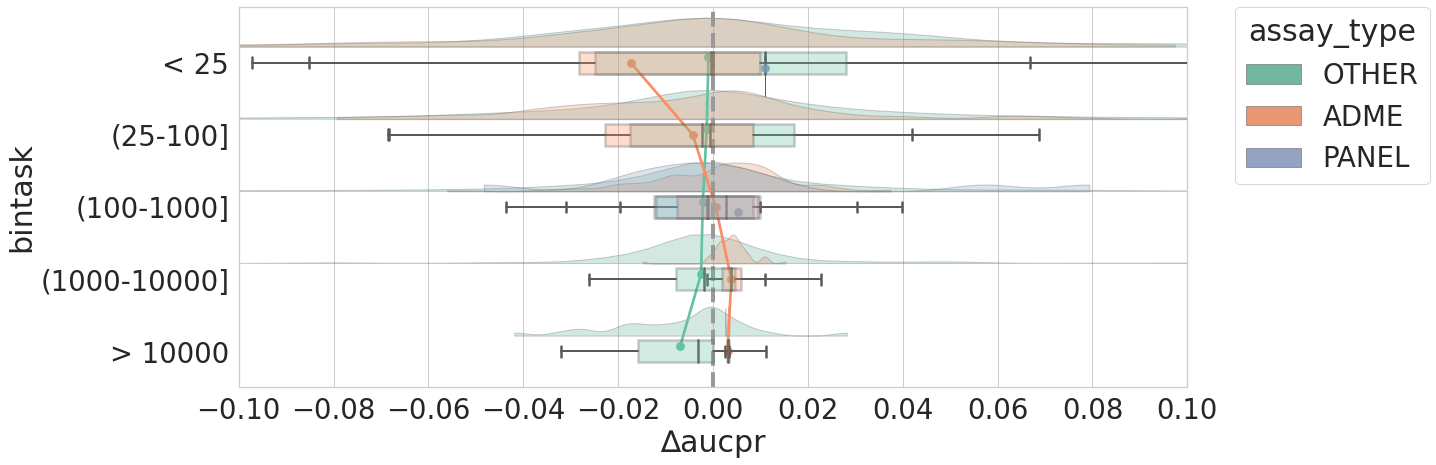

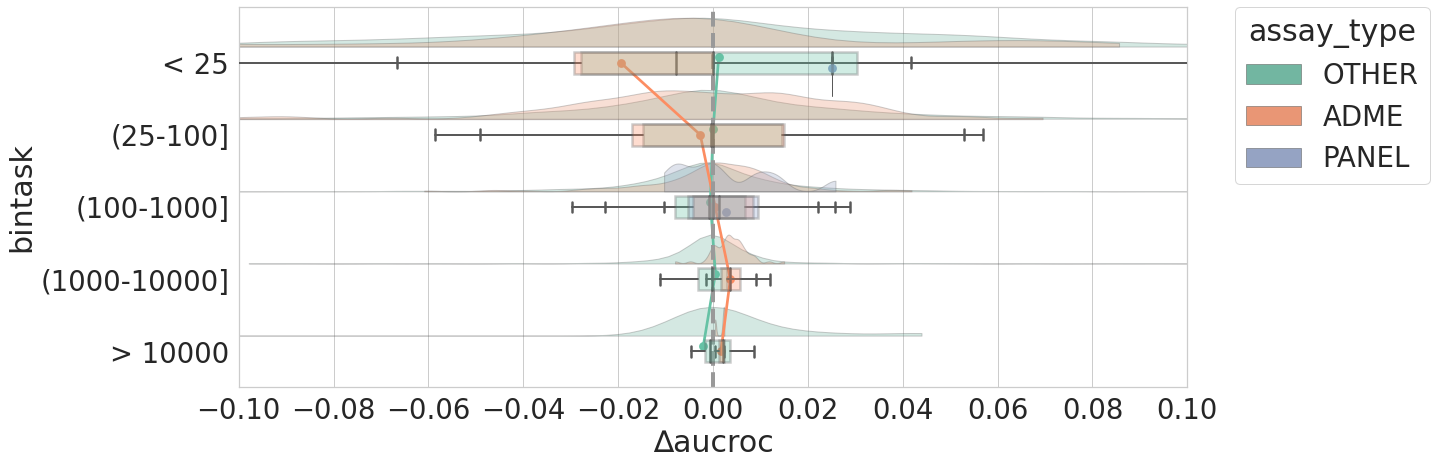

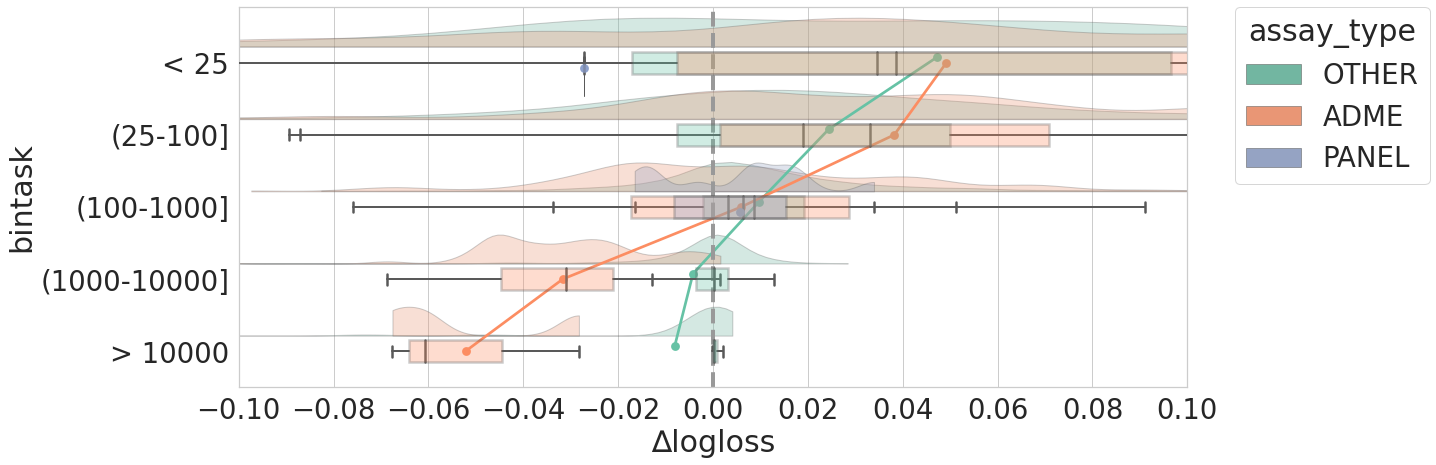

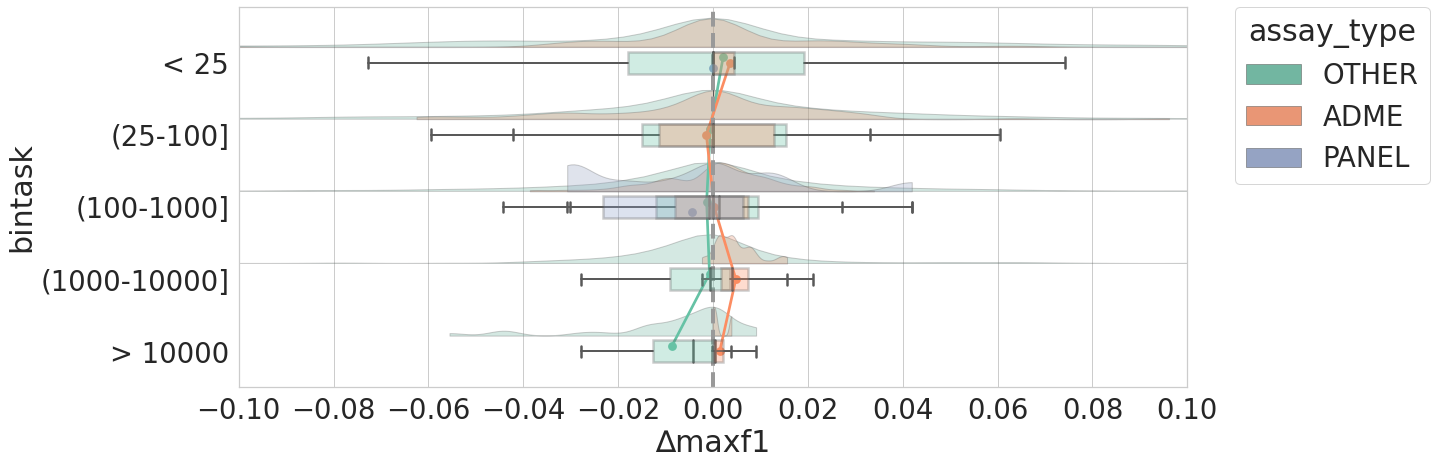

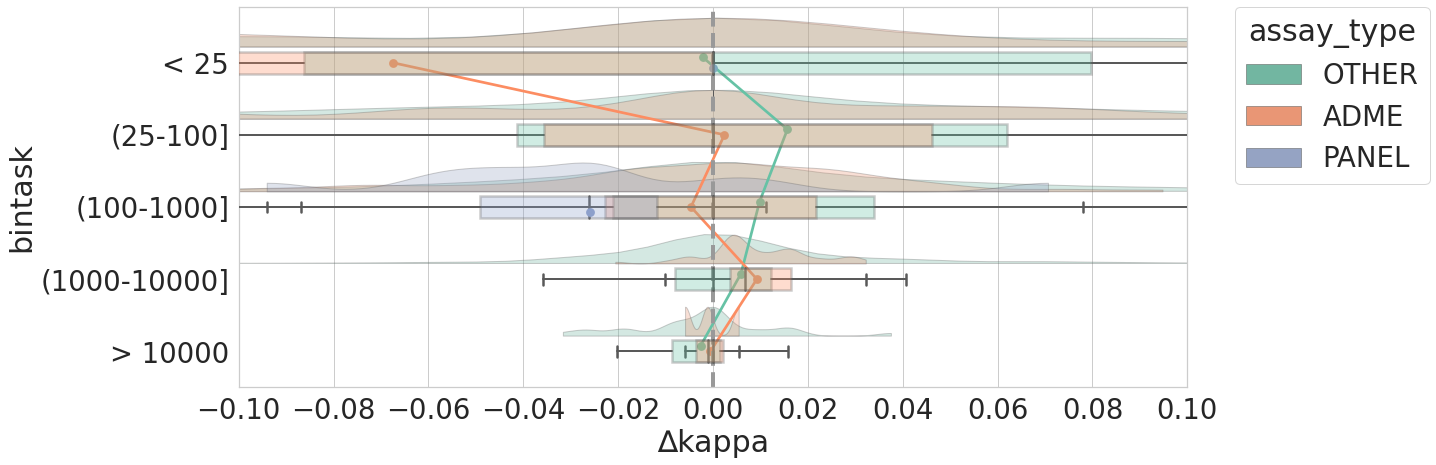

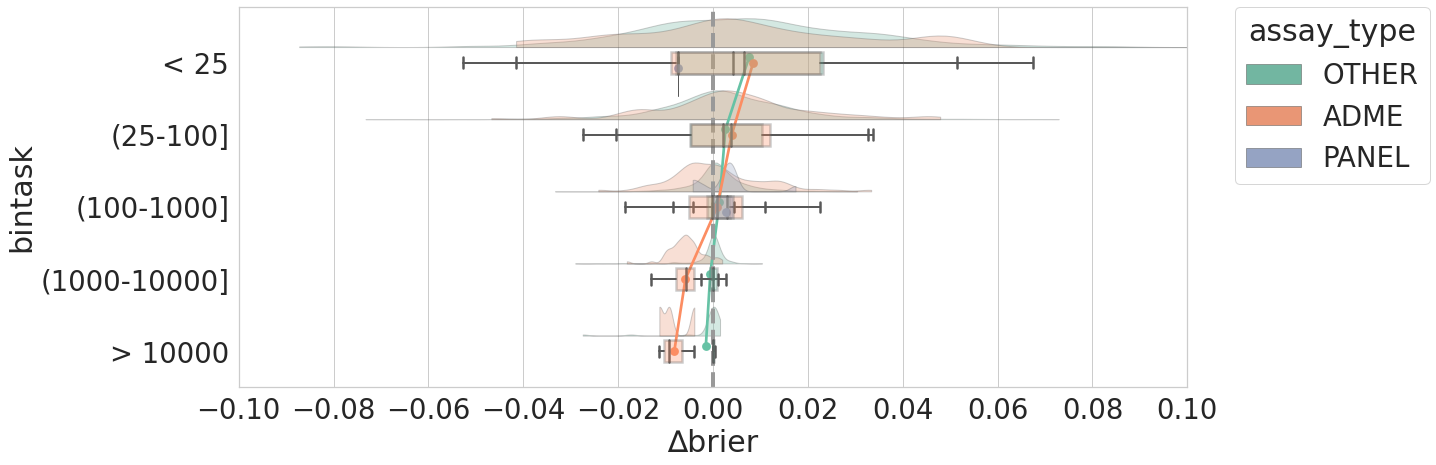

In [100]:
for metric_bin in f2_report.loc[:, "aucpr":"brier"].columns:
    plotDelta(metric_bin)